# Новое разбиение «T»

Регионы разбиваются на каскад из 3 ступеней:  
 1. `T0`. Bad – регионы, пересекающиеся с центромерами или регионы, где существуют базы с нулевым покрытием. Good – все остальные  
 2. `T1`. Bad – регионы из T0_good, пересекающиеся с all_diff более чем на 80%. Good – все остальные
 2. `T2`. Bad – регионы из T1_good, пересекаются со структурными вариантами более чем на 5%. Good – все остальные
 
Дополнительно, для построения регрессионной модели, регионы можно отранжировать по проценту непокрытых баз и по проценту пересечения с all_diff или с vcf, код:

In [2]:
def get_range_2(row):
    # T0 bad [0-1]
    if row['acent'] > 0 or row['covered_bases'] < 1:
        return 0 + row['covered_bases']

    # T1 bad [1-2]
    max_all_diff = 0.7
    if row['all_diff'] > max_all_diff:
        return 1 + (1 - row['all_diff']) / (1 - max_all_diff)

    # T1 good [2-3]
    return 2 + (1 - row['all_diff']/max_all_diff)


def get_range(row):
    if row['acent'] > 0 or row['covered_bases'] < 1: # T0 bad [0-1]
        return 0 + row['covered_bases']

    if row['all_diff'] > 0.8:                        # T1 bad [1-2]
        return 1 + (1 - row['all_diff']) / (1-0.8)

    vcfc = (row['hc_vcf'] + row['lc_vcf'])/2
    if vcfc > 0.05:                                  # T2 bad [2-3]
        return 2 + (1 - vcfc) / (1 - 0.05)

    return 3 + vcfc / 0.05                           # T2 good [3-4]

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_sample(name):
    dt = pd.read_csv(f'../../data/GIAB/_las_noappr/{name}_p14.lasbed', sep=' ')
    dt['Sample'] = name
    return dt

hg = [1,2,3,4,5,6,7]
LB = pd.concat([load_sample(f'HG00{i}') for i in hg])
LB = LB[LB['covered_bases'] > 0]

# Normalize
fft_m, fft_s = (1783.7347186000002, 263.58889402976223)
dtt_m, dtt_s = (9.111856, 0.06325841730085836)
LB['FFT_dF_n'] = (LB['FFT_dF'] - fft_m)/fft_s
LB['DTCWT_n'] = -(LB['DTCWT_Entropy'] - dtt_m)/dtt_s

# Range
LB['R'] = LB.apply(get_range, axis = 1)

with open('_matrix.n1b.json', 'r') as f:
    mat, xar, yar = [np.array(e) for e in json.load(f)]

# Globals: mat, xar, yar
def m_index(obj, v):
    if obj[0]  > v: return -2
    if obj[-1] < v: return -1
    return np.where(obj <= v)[0][-1]

def matrix(x, y):
    i, j = (m_index(xar, x), m_index(yar, y))
    if i == -2 or j == -2: return np.max(mat)
    if i == -1 or j == -1: return np.min(mat)
    return mat[i][j]  

# Matrix
nor7d = np.transpose([LB['FFT_dF_n'], LB['DTCWT_n']])
LB['matrix'] = [-matrix(x_, y_) for x_, y_ in nor7d]

# Linear combination
(dx, dy, scale) = (-1.232, 0.324, 0.072)
LB['LC'] = scale * (LB['FFT_dF_n'] + dx)**2 + (LB['DTCWT_n'] + dy)**2

# Sort
# LB = LB.filter(items=['Std','FFT_dF_n', 'DTCWT_n', 'matrix', 'LC', 'Sample', 'R'])
LB = LB.sort_values(by=['R'], ascending=False)

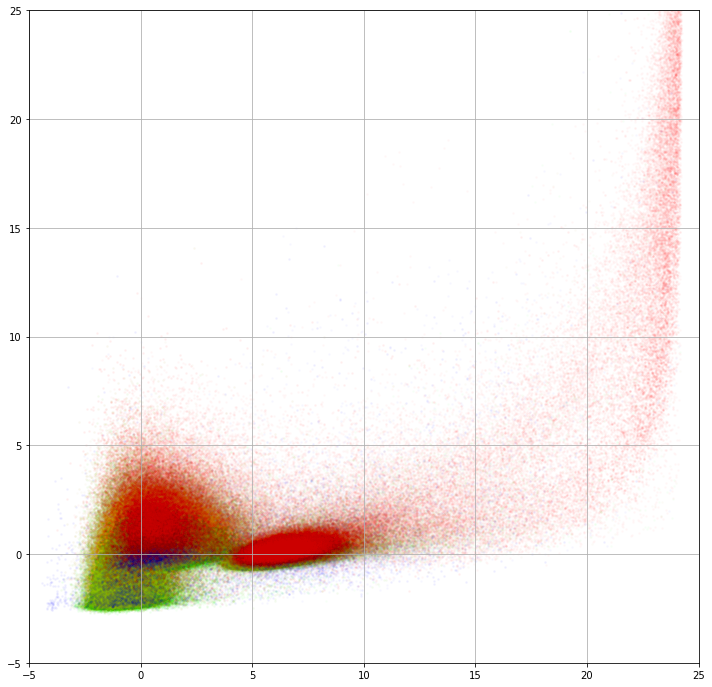

In [6]:
colors = ['#F00','#00F','#bfb900','#0F0']
plt.figure(figsize=(12, 12))
plt.grid()
xs, ys = ('FFT_dF_n', 'DTCWT_n')
tmp = [
    LB.loc[(LB['R'] < 1)], 
    LB.loc[(LB['R'] >= 1) & (LB['R'] < 2)], 
    LB.loc[(LB['R'] >= 2) & (LB['R'] < 3)],
    LB.loc[(LB['R'] >= 3)], 
]
for i in range(4):
    t = 3-i
    plt.scatter(tmp[t][xs], tmp[t][ys], alpha=0.02, s=2.5, color=colors[t])
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.show()

## Объединение метрик через регрессию

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

regr = LinearRegression()
X = LB[['FFT_dF_n','DTCWT_n']].values
Y = LB['R'].values

R = regr.fit(X, Y)
LB['Regr1'] = R.predict(X)

X2 = PolynomialFeatures(degree=2).fit_transform(X)
R = regr.fit(X2, Y)
LB['Regr2'] = R.predict(X2)

X3 = PolynomialFeatures(degree=3).fit_transform(X)
R = regr.fit(X3, Y)
LB['Regr3'] = R.predict(X3)

In [8]:
LB.to_csv('../../data/GIAB/_df_LReg.csv')
LB

,#chr,start,end,FFT_dF,DWT_Energy_Entropy,DTCWT_Entropy,Std,covered_bases,mean,variance,...,acent,Sample,FFT_dF_n,DTCWT_n,R,matrix,LC,Regr1,Regr2,Regr3
114560,chr11,68173825,68190208,1915.4003,1.9848,9.1473,0.1929,1.0000,59.9300,102.7318,...,0.0,HG004,0.499511,-0.560305,4.0000,-64.445473,0.094471,2.899368,2.998422,3.031700
92589,chr8,125550593,125566976,1630.4998,1.9678,9.2384,0.1513,1.0000,287.5140,1693.1748,...,0.0,HG001,-0.581341,-2.000429,4.0000,-61.739488,3.047166,3.028406,3.340519,3.314492
55464,chr5,29016065,29032448,1898.6380,1.9913,9.1030,0.1821,1.0000,57.8663,94.0786,...,0.0,HG002,0.435919,0.139997,4.0000,-62.828064,0.260923,2.873077,2.857866,2.881514
53535,chr4,187629569,187645952,3523.5977,2.1138,9.0797,0.3237,1.0000,14.6815,23.4547,...,0.0,HG005,6.600669,0.508328,4.0000,-32.248486,2.767997,2.475715,2.503544,2.479170
36254,chr3,102809601,102825984,1956.0677,2.0307,9.0896,0.1929,1.0000,51.2390,78.5003,...,0.0,HG003,0.653795,0.351827,4.0000,-62.828064,0.480813,2.850453,2.808425,2.837985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97438,chr9,59850753,59867136,7786.8973,2.1022,2.9695,0.0023,0.0012,0.0012,0.0012,...,1.0,HG005,22.774717,97.099426,0.0012,-0.000000,9524.738289,-2.694071,-1.148952,-0.427118
8048,chr1,131858433,131874816,7786.8973,2.1022,2.9695,0.0020,0.0012,0.0012,0.0012,...,1.0,HG006,22.774717,97.099426,0.0012,-0.000000,9524.738289,-2.694071,-1.148952,-0.427118
169964,chr21,7028737,7045120,7749.3300,1.6523,2.9122,0.0006,0.0010,0.0010,0.0010,...,1.0,HG004,22.632195,98.005234,0.0010,-0.000000,9701.612011,-2.724348,-1.279709,-0.486757
157116,chr17,83247105,83263488,4875.4262,1.3721,3.0136,0.0009,0.0010,0.0010,0.0010,...,0.0,HG003,11.729218,96.402285,0.0010,-0.000000,9363.908085,-1.980504,-9.155607,-1.387381


In [9]:
from _functions import *

In [10]:
reverce = len(LB) - np.arange(len(LB))
inv_norm = mergeSort(len(LB) - np.arange(len(LB)), len(LB))
invc = lambda x: mergeSort(x, len(x))/inv_norm

In [11]:
std_ref = invc(LB['Std'].tolist())
print(f"Std [ref]: {std_ref:.2f}")
for m in ['FFT_dF_n', 'DTCWT_n', 'matrix', 'LC', 'Regr1', 'Regr2', 'Regr3']:
    pc = std_ref/invc(LB[m].tolist()) - 1
    print(f"{m:<10} {pc:.1%}")

Std [ref]: 0.44
FFT_dF_n   3.9%
DTCWT_n    18.6%
matrix     16.9%
LC         16.6%
Regr1      -27.7%
Regr2      -32.1%
Regr3      -32.4%


## *Новое* репрезентативное разбиение на хорошие/плохие

`TR_0` - С покрытием, существует хоть одна непокрытая база, полностью лежат в all_diff  
`TR_1` - Полностью лежат в all_diff, 100% покрытых баз   
`TR_2` - Пересечения с all_diff < 5% и Std < 0.15  

In [99]:
tmp = LB.sample(frac = 1) # [LB['Sample'] == 'HG001']
TR = [
    tmp.loc[(tmp['all_diff'] == 1) & (tmp['covered_bases'] > 0) & (tmp['covered_bases'] < 1)],
    tmp.loc[(tmp['all_diff'] == 1) & (tmp['covered_bases'] == 1)],
    tmp.loc[(tmp['Std'] < 0.15) & (tmp['all_diff'] < 0.05)]
]

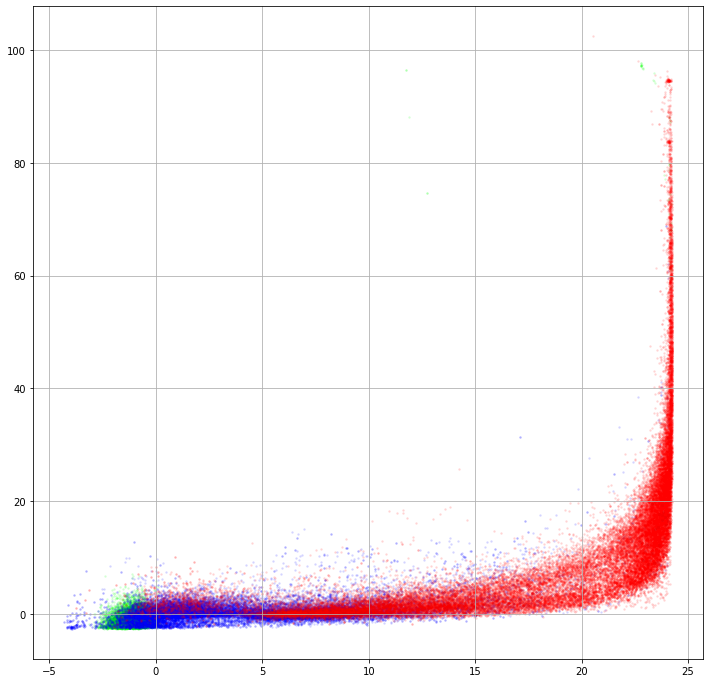

In [100]:
colors = ['#F00', '#00F','#0F0']
plt.figure(figsize=(12, 12))
plt.grid()
xs, ys = ('FFT_dF_n', 'DTCWT_n')
for i in range(3):
    plt.scatter(TR[2-i][xs], TR[2-i][ys], alpha=0.1, s=2.5, color=colors[2-i])
plt.show()

In [115]:
def hists(A, B):
    l, r = (min(A + B), np.quantile(A + B, 0.995))
    X = np.arange(l, r, (r-l)/80)
    return (np.histogram(A, bins=X)[0], np.histogram(B, bins=X)[0], X)
    
    
def tprfpr(A, B):
    dt = np.array([[v, 1] for v in A] + [[v, 0] for v in B])
    dt = dt[dt[:, 0].argsort()]
    tpr = np.cumsum(dt[:, 1])/np.sum(dt[:, 1])
    fpr = np.cumsum(1 - dt[:, 1])/(len(dt) - np.sum(dt[:, 1]))
    return (tpr, fpr, dt)


def acc(A, B, At, Bt):
    tpr, fpr, dt = tprfpr(A, B)
    dst = [(x**2 + (1-y)**2) for x,y in np.transpose([fpr, tpr])]
    t_ = dt[np.argmin(dst)][0]
    At, Bt = (np.array(At), np.array(Bt))
    acc_ = 0.5 * (len(At[At < t_])/len(At) + len(Bt[Bt >= t_])/len(Bt))
    #A, B = (np.array(A), np.array(B))
    #acc_ = 0.5 * (len(A[A < t_])/len(A) + len(B[B >= t_])/len(B))
    return (acc_, t_)


def getset(i, j, name):
    A, B = (TR[i], TR[j])
    return (
        A[A['Sample'] != 'HG002'][name].tolist(),
        B[B['Sample'] != 'HG002'][name].tolist(),
        A[A['Sample'] == 'HG002'][name].tolist(),
        B[B['Sample'] == 'HG002'][name].tolist(),
    )


def fnmax(name):
    accs = []
    axs = plt.figure(figsize=(18, 4), constrained_layout=True).subplots(1, 3)
    p = 0
    for i, j in [(1,0),(2,1),(2,0)]:
        A, B, At, Bt = getset(i, j, name)
        # A, B = (TR[i][name].tolist(), TR[j][name].tolist())
        ha, hb, xx = hists(At, Bt)
        axs[p].plot(xx[1:], ha/ha.sum())
        axs[p].plot(xx[1:], hb/hb.sum())
        (acc_, t_) = acc(A, B, At, Bt)
        axs[p].axvline(x=t_, color='red', linestyle='--')
        axs[p].set_title(acc_)
        accs.append(acc_)
        p += 1
    plt.suptitle(f'{name}')
    plt.show()
    return accs

In [119]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

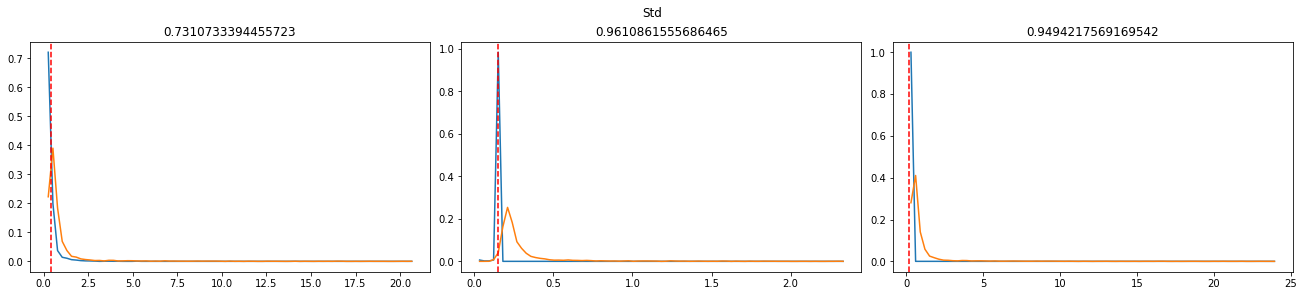

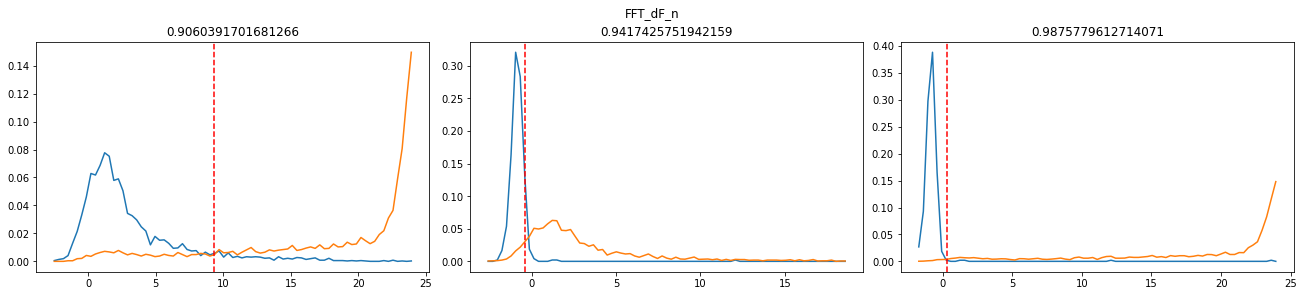

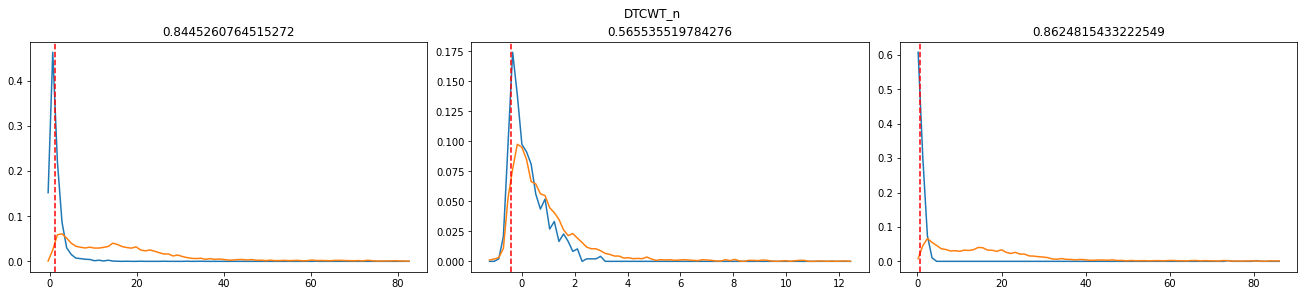

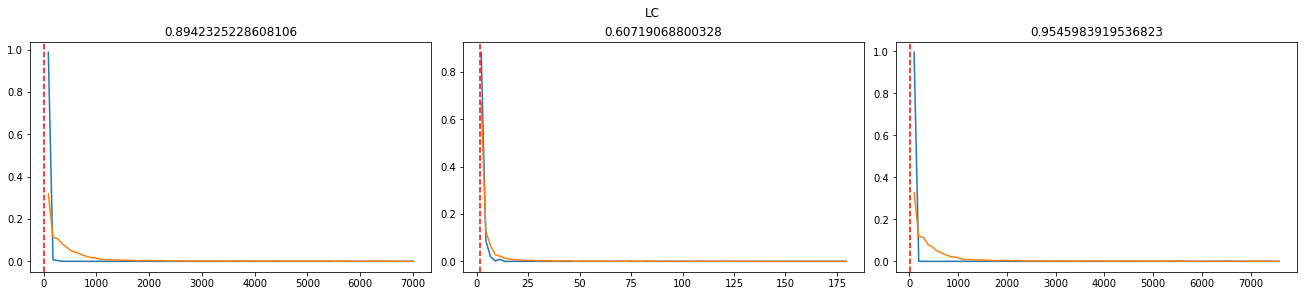

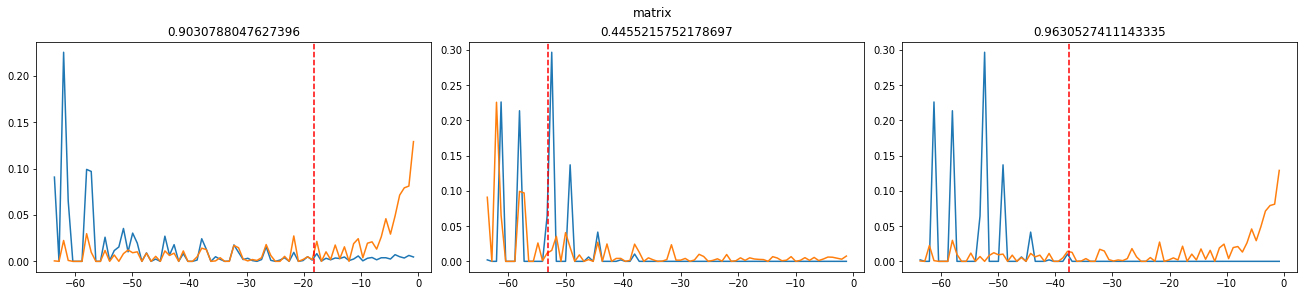

,Std,FFT_dF_n,DTCWT_n,LC,matrix
0,0.731073,0.906039,0.844526,0.894233,0.903079
1,0.961086,0.941743,0.565536,0.607191,0.445522
2,0.949422,0.987578,0.862482,0.954598,0.963053


In [124]:
names = ['Std', 'FFT_dF_n', 'DTCWT_n', 'LC', 'matrix']
df = pd.DataFrame({m:fnmax(m) for m in names})
df

In [121]:
import requests
TT = []
for df in [TR_0, TR_1, TR_2]:
    q = df[df['Sample'] == 'HG001'].filter(items=['#chr', 'start', 'end']).values.tolist()[0:100]
    TT.append(requests.post(f'http://127.0.0.1:9950/depth/HG001', json=q).json())

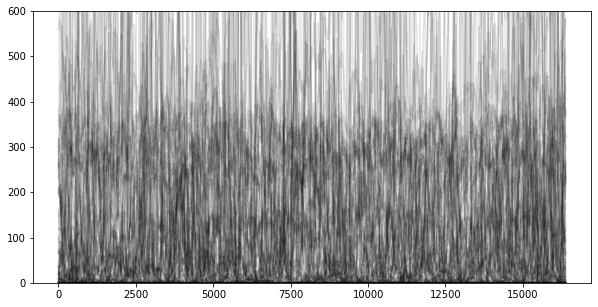

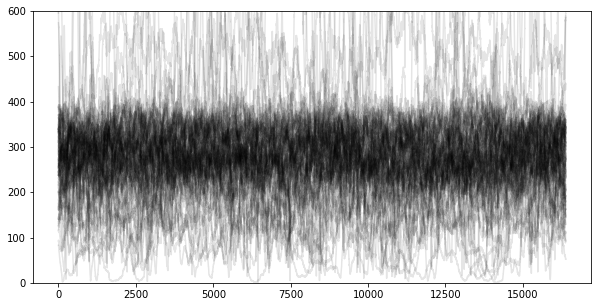

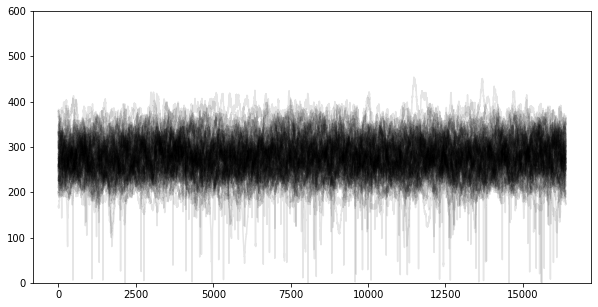

In [122]:
for sig in TT:
    plt.figure(figsize=(10, 5))
    plt.ylim(0,600)
    for one in sig:
        plt.plot(one, alpha=0.1, color='#000')    
    plt.show()

## Автокорреляционная функция

In [76]:
def autocorrelation(x):
    n, v = (len(x), x.var())
    x = x - x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    return r/(v * (np.arange(n, 0, -1)))

def ac_plot(ac):
    axs = plt.figure(figsize=(16, 4), constrained_layout=True).subplots(1, 2)
    ac_mean = np.array(ac).mean(axis=0)
    for a in ac:
        axs[0].plot(a[0:2**10], alpha=0.1)
        axs[1].plot(a[0:100], alpha=0.1)
    axs[0].plot(ac_mean[0:2**10], color='r')
    axs[0].grid()
    axs[1].plot(ac_mean[0:100], color='r')
    axs[1].grid()

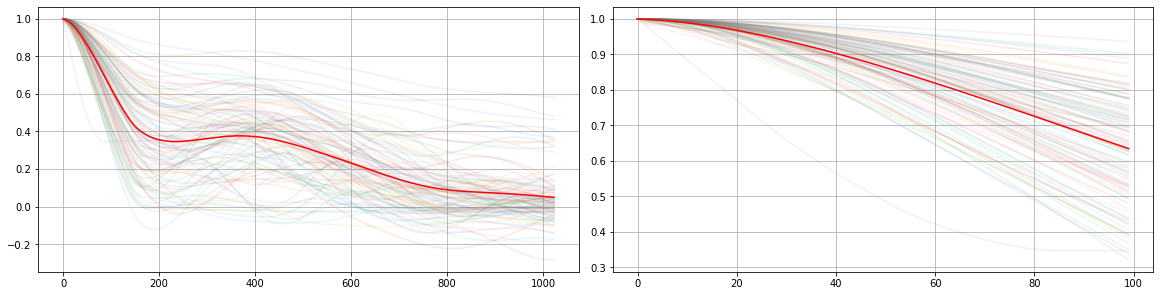

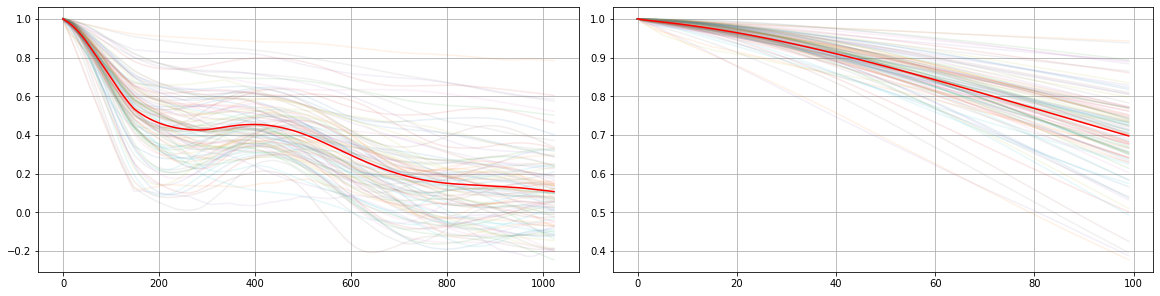

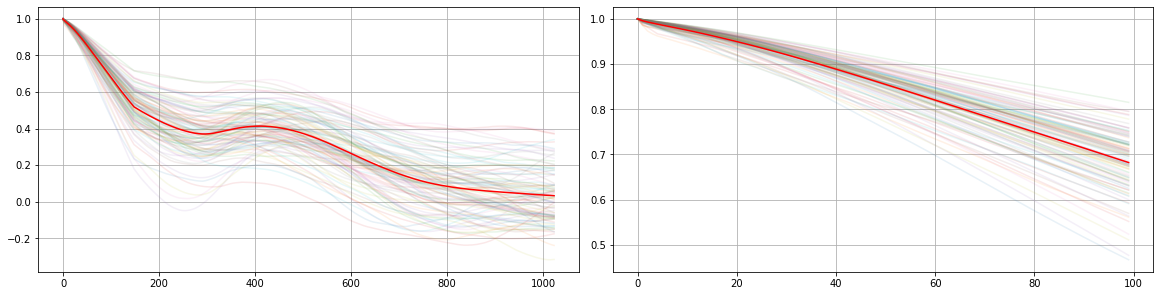

In [77]:
ac_plot([autocorrelation(np.array(reg)) for reg in TT[0]])
ac_plot([autocorrelation(np.array(reg)) for reg in TT[1]])
ac_plot([autocorrelation(np.array(reg)) for reg in TT[2]])

Обучим марковскую модель по репрезентативным регионам и сгенерируем искусственные данные покрытия:

In [79]:
def MM_train(signals, steps=4):
    model = {}
    inits = {}
    for signal in signals:
        k = str(signal[0])
        if k not in inits: inits[k] = 0
        inits[k] += 1
        for i in range(1, len(signal)):
            k = "-".join(str(x) for x in signal[max(i - steps, 0):i])
            if k not in model: model[k] = {}
            if signal[i] not in model[k]: model[k][signal[i]] = 0
            model[k][signal[i]] += 1
    return (inits, model, steps)

In [80]:
m0 = MM_train(TT[0])
m1 = MM_train(TT[1])
m2 = MM_train(TT[2])

In [85]:
def prob(obj):
    S = sum([obj[v] for v in obj])
    return np.random.choice(np.array([int(v) for v in obj]), p=[obj[v]/S for v in obj])
    

def generate(ims, size=256):
    init, model, steps = ims
    seq = [prob(init)]
    for i in range(1, size):
        k = "-".join(str(x) for x in seq[max(i-steps, 0):])
        if k in model: 
            seq.append(prob(model[k]))
        else:
            seq.append(prob(init))
    return seq


def mplot(tt):
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 600)
    for seq in tt:
        plt.plot(seq, alpha=0.1, color='#000')
    plt.show()

In [84]:
TM = [
    [generate(m0, 2**12) for i in range(100)],
    [generate(m1, 2**12) for i in range(100)],
    [generate(m2, 2**12) for i in range(100)]
]

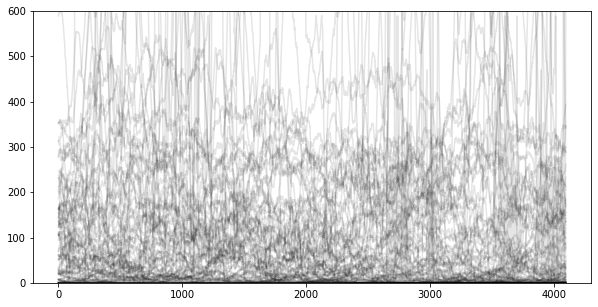

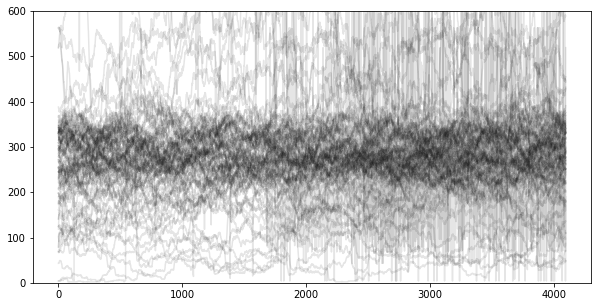

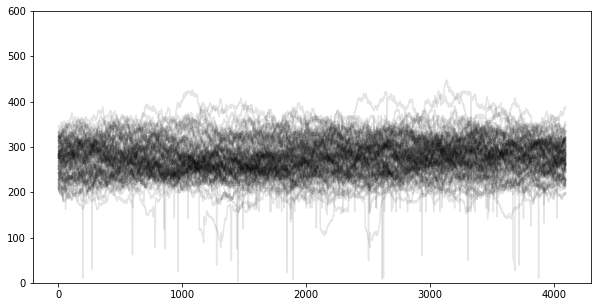

In [88]:
tmp = [mplot(tt) for tt in TM]

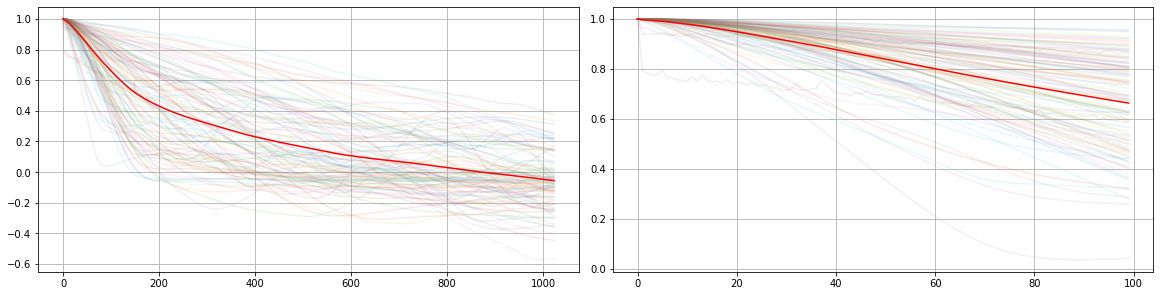

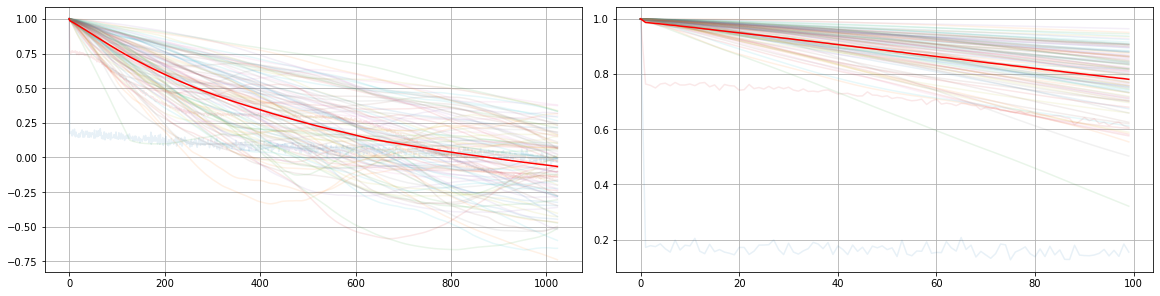

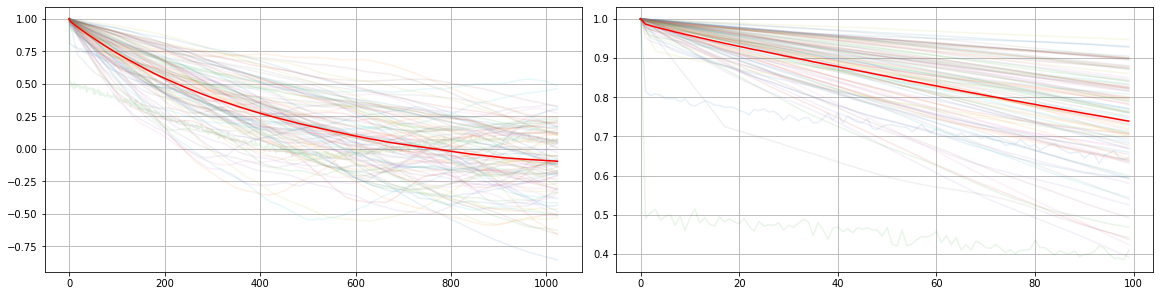

In [89]:
ac_plot([autocorrelation(np.array(reg)) for reg in TM[0]])
ac_plot([autocorrelation(np.array(reg)) for reg in TM[1]])
ac_plot([autocorrelation(np.array(reg)) for reg in TM[2]])

In [ ]:
colors = ['#F00', '#00F','#0F0']
plt.figure(figsize=(12, 12))
plt.grid()
xs, ys = ('FFT_dF_n', 'DTCWT_n')
for i in range(3):
    #t = 2-i
    #for seq in TM[t]:
    #plt.scatter(TM[xs], TM[ys], alpha=0.1, s=2.5, color=colors[t])
plt.show()